### Representing and minimizing rules

*(You'll need to: `conda install pyrsistent networkx` and then `pip install nxpd`. You'll also need graphviz.)*

Our rules are represented as positive monotone formulae in CNF. This is flexible enough for practical purposes, while still allowing us to define a normal form suitable for diffing, etc.

A _clause_ is a set of literals, and a _formula_ a set of clauses. We sort each first by size, then lexicographically. Other than that, we just need a bunch of boilerplate functionality.

In [1]:
class Clause:
    def __init__(self, *args):
        self.literals = frozenset(args)
        
    def first(self):
        return next(iter(self.literals))
    
    def issubset(self, other):
        return self.literals.issubset(other.literals)
    
    def elements(self):
        return self.literals
        
    def __str__(self):
        return ", ".join(map(str, sorted(self.literals)))
    
    def _repr_pretty_(self, p, cycle):
        p.text(str(self) if not cycle else '...')
    
    def __len__(self):
        return len(self.literals)
    
    def __lt__(self, other):
        if len(self.literals) == len(other.literals):
            return sorted(self.literals) < sorted(other.literals)
        return len(self.literals) < len(other.literals)
    
    def __eq__(self, other):
        return self.literals == other.literals
    
    def __hash__(self):
        return hash(self.literals)
    
    def __repr__(self):
        return '<{}>'.format(''.join(self.literals))

In [2]:
class Formula:
    def __init__(self, *args):
        self.clauses = set(args)
        
    def first(self):
        return next(iter(self.clauses))

    def issubset(self, other):
        return self.clauses.issubset(other.clauses)
    
    def elements(self):
        return self.clauses

    def __len__(self):
        return len(self.clauses)
        
    def __str__(self):
        return " ".join(map(lambda x: "({})".format(x), sorted(self.clauses)))
    
    def _repr_pretty_(self, p, cycle):
       p.text(str(self) if not cycle else '...')
    
    def __lt__(self, other):
        if len(self.clauses) == len(other.clauses):
            return sorted(self.clauses) < sorted(other.clauses)
        return len(self.clauses) < len(other.clauses)

And some utility functions for constructing formulae...

In [3]:
def formula(*sets):
    return Formula(*map(lambda s: Clause(*s), sets))

def parse(str):
    return formula(*(set(clause) for clause in str.split(' ')))
    
def forms(*strs):
    return [normalize(parse(str)) for str in strs]

In [4]:
formula({'a', 'b', 'c'}, {'ab', 'e'}, {'a', 'ab', 'c'})

(ab, e) (a, ab, c) (a, b, c)

But from now on, we'll just use single letters for literals, so we can make use of `forms()` and `parse()`.

For any formula, we define a normal form which exists, is unique, and is equivalent to the original formula under the usual interpretation of boolean logic.

Clauses are always normal, since all literals are positive. Formulae are normalized by removing any clause subsumed by any other. A clause $c$ is _subsumed_ by a clause $s$ if $s \subseteq c$. This is the obvious $O(mn)$ algorithm. Our clauses are almost always of size 1, so this is just fine.

In [5]:
def subsumes(c, d):
    return c.literals.issubset(d.literals)

def normalize(formula):
    minimized = set()
    for c in formula.clauses:
        minimized = {s for s in minimized if not subsumes(c, s)}
        if not any(subsumes(s, c) for s in minimized):
            minimized.add(c)
    return Formula(*minimized)

In [6]:
form = parse('ab b a cd acd cd')
form

(a) (b) (a, b) (c, d) (a, c, d)

In [7]:
normalize(form)

(a) (b) (c, d)

Note that `forms()` above returns formulae already normalized:

In [8]:
forms('ab b a cd acd cd')

[(a) (b) (c, d)]

### Matching

The problem of matching rules to contexts amounts to testing formulae against truth-value assignments. But there are a few particularities which apply to our setting...

 - we want to evaluate rules under partial assignments as well as total assignemnts, identifying
   rules which are not yet satisfied, but remain satisfiable by future assignments.
 - we're always monotonically extending partial assignments and then re-evaluating, so it seems 
   like a good idea to re-use the current state as a starting point for future evaluations.
 - many assignments will co-exist at the same time, and each may subsequently be used as the
   starting point for future evaluations.
   
If we use an algorithm that just freshly evaluates all the rules against each assignment from scratch, there's not much more to do. If, however, we want to use an algorithm that performs work incrementally from the prior assignment, then we also want persistent data structures so that the old and new states can co-exist without copying.

Here are some ideas...

#### Brute force

 1. Index rules by properties set in that context
 2. Do nothing else until a property is requested
 3. Find all rules setting that property
 4. Evaluate each rule against the current assignment
 5. Apply specificity logic, etc.
 
This might be just fine, particularly if there are lots of different properties with only a few settings each. For situations where lots of properties are queried and set in the same context, there are some simple tricks that could speed things up. For instance, a given rule could be marked as satisfied (or not) by a given assignment so that future properties queried in the same context wouldn't need to reevaluate those rules. But in the case where are many, many settings of the same property in a large number of different rules, this seems unavoidably pretty bad.

There maybe other use cases for which this approach wouldn't work as well. For instance, enumerating properties set in a given context, or enumerating all the possible values of a given key that could be added to reveal additional settings. Those are more rare, though, and it would be ok if they were more expensive, as long as they're tractable.

#### DAG/Rete

 1. Use rules to build an immutable graph, with root nodes for each literal
 2. As the context is extended with additional facts, propagate those facts through the graph,
    activating child nodes as appropriate
 3. When a node containing property settings is activated, add those settings to the properties
    visible in the current context
 4. Apply specificity logic, either separately or in step 3 when adding settings
 
This is most similar to the current implementation, and most similar to what I've implemented so far for CCS2. Given the requirements above, the node activation state must be kept separately from the main graph, and in a persistent data structure. Likewise the visible settings.

Querying properties and enumerating properties are both trivial. The problem of enumerating key values remains tricky, but I've already implemented one variant and it's not too bad.

There are lots of variants of this involving different approaches to building the dag. Since we're dealing with CNF terms, one possibility is to build a graph for disjunctions and one for conjunctions (or, equivalently, a single graph in two layers). The only thing remaining then is to optimize the structure of each of those graphs to amortize work done at each step.

#### Other matching approaches

There are other matching approaches to indexing and matching boolean formulae. Perhaps one of these would be better, but it would need to support partial matching (to find satisfiable but not yet satisfied rules), and may need to support an incremental implementation using immutable data structures, depending on its overall performance.

###  The DAG approach

So let's give this approach a try... The dag will be rooted with a bunch of literals, which in actual practice consist of key/value-pattern matchable forms, but for now we'll just leave opaque.

Nodes consist of an operation (and/or), an activation tally count, their children and their property settings. The top-level dag contains an otherwise unused node for the root-level settings.

In [9]:
from enum import Enum
class Op(Enum):
    AND = 'AND'
    OR = 'OR'

class Node:
    def __init__(self, op, specificity):
        self.op = op
        self.specificity = specificity
        self.tallyCount = 1 if self.op == Op.OR else 0
        self.children = []
        
    def add_link(self):
        if self.op == Op.AND:
            self.tallyCount += 1

from collections import defaultdict

class Dag:
    def __init__(self):
        self.children = defaultdict(list)

Here we build a single dag containing both clauses and formulae, but the design is easier to understand if we regard them as two separate graphs. Consider the graph of clauses. The invariant is that a node represenging a clause $c$ needs to be reachable from exactly those root nodes representing literals $l \in c$. It must be reachable via some path from each of those root nodes, and not reachable from any others.

Subject to this, and without being too precise, the goal is to minimize the number of edges and also to minimize 
fan-out from any node. Intuitively, we want to minimize the duplication of work for overlapping formulae. Also, since we have no reason to believe that any particular fact will become true in the future, we also want to minimize the expected amount of work we have to do for any incremental addition of bindings to our assignment, deferring as much work as possible.

To build the dag, we build the whole thing in two phases, first adding all clauses from smallest to largest, then adding all formulae likewise. For this reason, we require the complete set of formulae up-front. We use the greedy set-cover approximation algorithm for each phase. NB: Here we rely on the fact that clauses and formulae are both ordered from smallest to largest.

For reasons that will become clear below, we force every single-element clause to build a disjunction node, but single-element formulae can simply reuse the disjunction node below them as their own.

In [10]:
import heapq
from functools import total_ordering

@total_ordering
class Rank:
    def __init__(self, elem):
        self.weight = len(elem)
        self.elem = elem
        
    def __eq__(self, other):
        return self.weight == other.weight and self.elem == other.elem
    
    def __lt__(self, other):
        if self.weight == other.weight:
            return self.elem > other.elem
        return self.weight > other.weight
        
def build(expr, op, base_children, these_children):
    # TODO need a special case for the empty formula
    if op == Op.AND and len(expr) == 1:
        return base_children[expr.first()]
    
    ranks = defaultdict(list)
    sizes = []
    for c in these_children:
        if c.issubset(expr):
            if len(c) == len(expr):
                return these_children[c]
            rank = Rank(c)
            sizes.append(rank)
            for l in c.elements():
                ranks[l].append(rank)
    heapq.heapify(sizes)
    covered = set()
    node = Node(op, len(expr))

    while len(sizes) and sizes[0].weight != 0:
        best = heapq.heappop(sizes).elem
        these_children[best].append(node)
        node.add_link()
        for l in best.elements():
            if l not in covered:
                covered.add(l)
                for rank in ranks[l]:
                    rank.weight -= 1
        # TODO this repeated linear heapify is no good, we need a heap that allows us to
        # shuffle elements up and down as needed
        heapq.heapify(sizes)

    for l in expr.elements() - covered:
        base_children[l].append(node)
        node.add_link()

    return node.children

def build_dag(formulae):
    dag = Dag()
    clause_children = {}
    for clause in sorted({c for f in formulae for c in f.clauses}):
        clause_children[clause] = build(clause, Op.OR, dag.children, clause_children)
    form_children = {}
    for form in sorted(formulae):
        form_children[form] = build(form,  Op.AND, clause_children, form_children)        
    return dag

In [11]:
dag = build_dag(forms('a b c', 'a b', 'b c efg', 'b d ef', 'b'))

Let's take a look at the result:

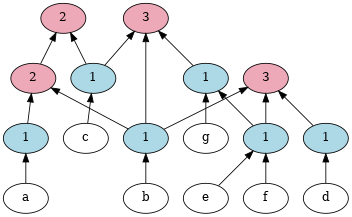

In [12]:
import networkx as nx
import nxpd

nxpd.nxpdParams['show'] = 'ipynb'

# t will be used later...
def draw(dag, t={}):
    G = nx.DiGraph()
    G.graph['dpi'] = 60
    G.graph['rankdir'] = 'BT'
    def add_nodes(p, ns):
        for n in ns:
            count = t.get(n, n.tallyCount)
            label = str(n.tallyCount)
            if count == 0:
                color = 'palegreen'
            elif n.op == Op.OR:
                color = 'lightblue'
            elif count != n.tallyCount:
                color = 'mistyrose'
                label = "{} / {}".format(n.tallyCount - count, label)
            else:
                color = 'pink2'
            G.add_node(n, label=label, style='filled', fillcolor=color)
            G.add_edge(p, n)
            add_nodes(n, n.children)
    for l, ns in dag.children.items():
        G.add_node(l)
        add_nodes(l, ns)
    
    return nxpd.draw(G)
    
draw(dag)    

#### Examples

Here are a few more little examples from my notes, just to show a few features of the way these dags are built.

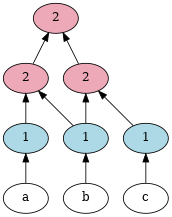

In [13]:
draw(build_dag(forms('a', 'b', 'c', 'a b', 'b c', 'a b c')))

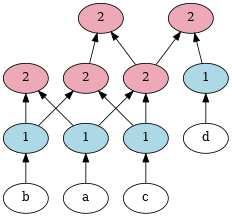

In [14]:
draw(build_dag(forms('a', 'b', 'c', 'a b', 'b c', 'a b c', 'a c', 'a c d')))

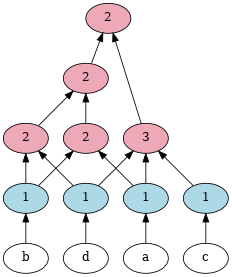

In [15]:
draw(build_dag(forms('a b c d', 'a b d', 'a c d', 'b d', 'a b')))

This algorithm will never create an intermediate node, so it'll only discover sharing among expressions that are actually present in the input. Compare the following:

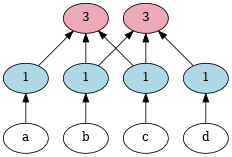

In [16]:
draw(build_dag(forms('a b c', 'b c d')))

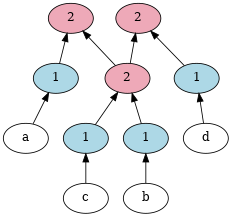

In [17]:
draw(build_dag(forms('a b c', 'b c d', 'b c')))

But our input files themselves often contain strong hints about that, such as:

    b c {
      a {...}
      d {...}
    }
    
So we can get some mileage by exploiting these structures when we build the list of formulae.

We'll parse the above into a tree of formulae, all normalized:

    b c
     a b c
     b c d
        
For each branch, we'll check whether the parent is a subset of more than one of its children. If so, we add the parent formula to our set. Otherwise, we drop it.

So, for

    b {
      c {
        a {...}
        d {...}
      }
    }
    
we find this tree:

    b
      b c
       a b c
       b c d

We eliminate `b`, but retain `b c`.

For

    (a, b) {
      a {...}
      c {...}
    }
    
we find

    ab d
     a d
     ab c d

and since `ab d` is a subset of only one of its children, we eliminate it, saving one node.

Note that there are cases where this still builds unused temporary nodes. For instance:

    a b c {...}
    a b {
      c d {...}
      c e {...}
    }

The `a b` node will be included in this case, optimistically hoping that it'll be used for `a b c d` and `a b c e`, but in fact both of those will take advantage of `a b c` instead, leaving `a b` with no children. Orphaned nodes like that could just be ignored, they could be cleaned out at the end, or maybe the above subset heuristic could be improved to detect them sooner.

We'll implement all of this later, when we're actually dealing with the full syntax.

#### Matching

Meanwhile, let's talk about matching against these dags. This part is simple. We just start at the correct root for the newly added literal fact, and activate whichever nodes we reach, decrementing the tally count of each. We activate a node's children only when its tally count reaches *exactly* zero. This prevents duplicate activations in the case of disjunctions. (It would also allow an easy way to poison nodes, if ever needed.) We also need to be careful not to allow duplicate literals, but forcing each single-element clause to build a one-input disjunction node accomplishes that as well.

Finally, we keep the tally counts in a persistent map so that we can fork them as discussed above.

In [18]:
from pyrsistent import m, s

class Context:
    def __init__(self, dag, tallies=m()):
        self.dag = dag
        self.tallies = tallies
        
    def augment(self, literal):
        tallies = self.tallies
        
        def activate(n):
            nonlocal tallies
            count = tallies.get(n, n.tallyCount)
            if count > 0:
                count -= 1
                tallies = tallies.set(n, count)
                if count == 0:
                    for n in n.children:
                        activate(n)
        
        for n in dag.children[literal]:
            activate(n)
        return Context(self.dag, tallies)

In reality, there will be some extra wrinkles pertaining to the more complex real-world structure of literals, property settings, specificities, rule-activated fact augmentations, and so on. But it's all fairly straightforward after this.

In [19]:
dag = build_dag(forms('a b c', 'a b', 'b c efg', 'b d ef', 'b'))
root = Context(dag)
c = root.augment('b')

Let's take a look at the state of a graph in context as well:

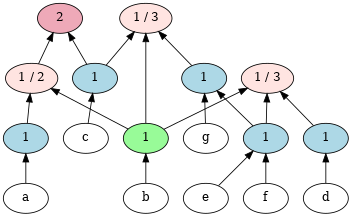

In [20]:
draw(dag, c.tallies)

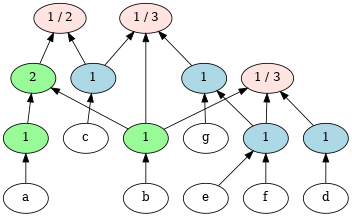

In [21]:
draw(dag, c.augment('a').tallies)

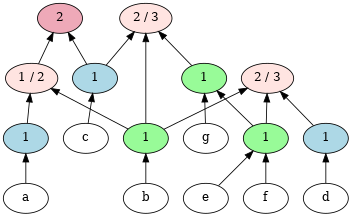

In [22]:
draw(dag, c.augment('e').tallies)

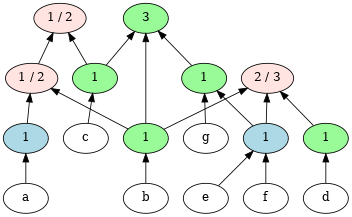

In [23]:
from functools import reduce
def augmentAll(c, ls):
    return reduce(lambda c, l: c.augment(l), ls, c)
draw(dag, augmentAll(root, 'bdcg').tallies)

As a reminder, the rules for these examples were

    forms('a b c', 'a b', 'b c efg', 'b d ef', 'b')

so those activations are exactly as expected.

This example shows the necessity of tracking dirty literals:

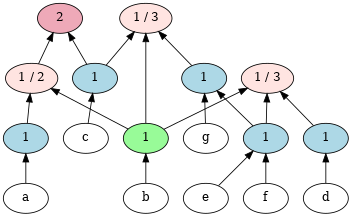

In [24]:
draw(dag, augmentAll(root, 'bb').tallies)

Rather than forcing an indirection of every literal through a disjunction node, we could also just track dirty literals explicitly. But the current approach is probably better, since we need a node on which to hang settings and constraints in any case. And it's more consistent and simpler, even if it makes the pictures a little uglier.

### Getting to CNF

It may be more convenient to specify rules as arbitrary boolean expressions (as is allowed in CCS1). If so, we'll convert them to CNF, and can report an error if a formula expands beyond a fixed maximum size.

In [25]:
def merge(*forms):
    return Formula(*frozenset().union(*(f.elements() for f in forms)))

from collections import namedtuple
Expr = namedtuple('Expr', 'op children')

def cnfify(expr):
    if type(expr) == str:
        return formula({expr})
    if expr.op == Op.AND:
        return merge(*map(cnfify, expr.children))
    elif expr.op == Op.OR:
        return expand(list(map(cnfify, expr.children)))
    
def expand(forms):
    if len(forms) == 1:
        return forms[0]
    else:
        cs = (merge(c1, c2) for c1 in forms[0].elements() for c2 in expand(forms[1:]).elements())
        return Formula(*cs)

In [26]:
merge(*forms('a b c', 'b cd', 'b'))

(a) (b) (c) (c, d)

In [27]:
e = Expr(Op.OR, [Expr(Op.AND, ['a', 'b']), Expr(Op.AND, ['c', 'd'])])

In [28]:
cnfify(e)

((a) (c)) ((a) (d)) ((b) (c)) ((b) (d))